In [1]:
from random import shuffle

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models


In [2]:
def mnist_loader(path=None, train=True):
    if path is None:
        path = "data"
    return datasets.MNIST(
        root=path,
        train=train,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                # transforms.Normalize(mean=0.5, std=0.5),
            ]
        ),
        download=True,
    )


In [3]:
class Bag:
    def __init__(
        self,
        positive_instance_label=0,
        bag_size=(10, 50),
        pov_neg_ins_ratio=(0.2, 0.5),
        bag_number=(100, 100),
        mnist_path="data",
        seed=0,
    ):
        """Initalise for Bag

        Args:
            positive_instance_label (int, optional): Label that consider as positive in MNIST. Defaults to 0.
            bag_size (tuple, optional): Number of instance in each bag. Defaults to (10,50).
            pov_neg_ins_ratio (tuple, optional): Positive negative instance ratio in each bag. Defaults to (0.2,0.5).
            bag_number (tuple, optional): Number of (Positive, Negative) Bags. Defaults to (100,100).
            mnist_path (str, optional): Root directory of dataset where MNIST/raw/train-images-idx3-ubyte and MNIST/raw/t10k-images-idx3-ubyte exist.. Defaults to 'data'.
            seed (int, optional): Seed for randomization. Defaults to 0.

        Returns:
            train,test: train and test bag
        """
        self.pos_label = positive_instance_label
        self.bag_size = bag_size
        self.pov_neg_ins_ratio = pov_neg_ins_ratio
        self.bag_number = bag_number
        self.mnist_path = mnist_path
        self.seed = seed
        self.__mnist_loader()
        self.__gen_bags()
        self.bag_list = []
        self.bag_list.extend(zip(self.pos_bag_list, torch.ones(len(self.pos_bag_list),1)))
        self.bag_list.extend(zip(self.neg_bag_list, torch.zeros(len(self.neg_bag_list),1)))
        shuffle(self.bag_list)

    def __mnist_loader(self):
        self.pos_instance = []
        self.neg_instance = []
        np.random.seed(self.seed)

        """
        # Extend img,label list with tensor as element
        #! Error
        for status in [True, False]:
            tmp = mnist_loader(path=self.mnist_path, train=status)
            self.neg_instance.extend(zip(tmp.data, tmp.targets))
        # print('len_neg_ins',len(self.neg_instance))
        # count = 0
        # Seperate +/- instance
        for idx, instance in enumerate(self.neg_instance):
            if int(instance[1].numpy()) == self.pos_label:
                # count += 1
                # print('matched:[',int(instance[1].numpy()),' <->',self.pos_label)
                self.pos_instance.append(self.neg_instance.pop(idx))
            else:
                print(int(instance[1].numpy()),end='')
        """
        for status in [True, False]:
            tmp = mnist_loader(path=self.mnist_path, train=status)
            for data in tmp:
                if data[1] == self.pos_label:
                    self.pos_instance.append(data)
                else:
                    self.neg_instance.append(data)
        
        # print(count, len(self.neg_instance))
        # Randomize instance sequence
        shuffle(self.pos_instance)
        shuffle(self.neg_instance)
        # tmp = []
        # for img,idx in self.pos_instance:
        #     if  idx != 0:
        #         tmp.append(int(idx.numpy()))
        # print(tmp)

    def __gen_bags(self):
        self.pos_bag_list = []
        self.neg_bag_list = []
        # Generate Positive Bags
        for i in range(self.bag_number[0]):
            bag = []
            try:
                bag_size = np.random.randint(*self.bag_size)
            except:
                bag_size = self.bag_size[0]
            pos_size = round(
                (
                    np.random.random()
                    * (self.pov_neg_ins_ratio[1] - self.pov_neg_ins_ratio[0])
                    + self.pov_neg_ins_ratio[0]
                )
                * bag_size
            )
            for j in range(pos_size):
                if self.pos_instance:
                    bag.append(self.pos_instance.pop(0)[0])
                else:
                    break
            for j in range(bag_size - len(bag)):
                if self.neg_instance:
                    bag.append(self.neg_instance.pop(0)[0])
                else:
                    break
            self.pos_bag_list.append(bag)
        neg_index_list = []
        for i in range(self.bag_number[1]):
            bag = []
            try:
                bag_size = np.random.randint(*self.bag_size)
            except:
                bag_size = self.bag_size[0]
            for j in range(bag_size):
                if self.neg_instance:
                    tmp_instance = self.neg_instance.pop(0)
                    bag.append(tmp_instance[0])
                    neg_index_list.append(tmp_instance[1])
                else:
                    break
            self.neg_bag_list.append(bag)
        # print(neg_index_list)

        shuffle(self.pos_bag_list)
        shuffle(self.neg_bag_list)


In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2),
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(14 * 14 * 128, 1024),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(1024, 10),
        )

    def forward(self, x):
        # print(x.shape)
        feats = self.conv1(x)
        # print(x.shape)
        flatten = feats.view(-1, 14 * 14 * 128)
        # print(x.shape)
        c = self.dense(flatten)
        return flatten, c


In [5]:
class B_CLF(torch.nn.Module):
    def __init__(self):
        super(B_CLF, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(14*14*128, 128),
            torch.nn.Sigmoid(),
            torch.nn.Linear(128,2),
            # torch.nn.ReLU(),
            # torch.nn.Linear(64, 2),
            # torch.nn.Linear(30 * 10, 2)
        )

    def forward(self, feats):
        x = self.fc(feats)
        # print(x)
        return feats,x


In [6]:
model = CNN()
b_clf = B_CLF()
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
bag = Bag(bag_size=(30,30))
length = len(bag.bag_list)
train_bags, test_bags = torch.utils.data.random_split(
    bag.bag_list, [int(0.8 * length), int(0.2 * length)]
)
check_dict = {'true':[], 'false':[]}
z = 0
for bags,label in train_bags:
    if z%20 != 0:
        z+=1
        continue
    else:
        z = z+1
    label = int(label.numpy()[0])
    for instance in bags:
        if label == 1:
            check_dict['true'].append(instance[0])
        else:
            check_dict['false'].append(instance[0])

5879


(array([5879.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

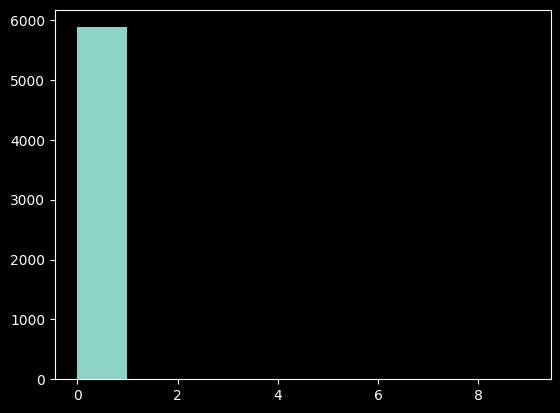

In [7]:
print(len(bag.pos_instance))
q = 0
label_list = []
for idx, instance in enumerate(bag.pos_instance):
    label_list.append(instance[1])
plt.hist(label_list,[0,1,2,3,4,5,6,7,8,9])

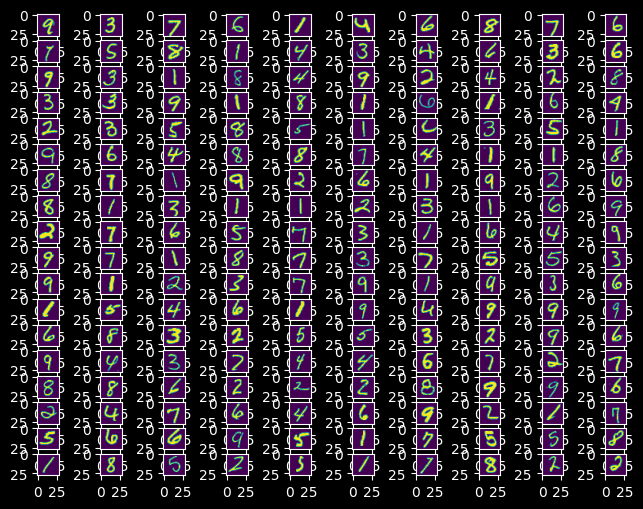

In [8]:
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 24
for idx, instance in enumerate(check_dict['false']):
    fig.add_subplot(rows, columns, idx+1)
    plt.imshow(instance)
plt.show()

In [9]:
# a.dataset = train bag
# a.dataset[0] = first bag in train bag
# a.dataset[0][0] = instances in first bag (removed bag label)
# a.dataset[0][0][0] = first instance in first bag
# plt.imshow(train_bags.dataset[0][0][0],cmap='gray')

In [10]:
for epoch in range(3):
    running_loss = 0.0
    count = 0
    for instances, label in train_bags:
        # print(label)
        count += 1
        instance_features = None
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        instances = torch.utils.data.DataLoader(instances,shuffle=True)
        for instance in instances:
            flatten, c = model(instance.to(torch.float32))
            if instance_features is None:
                instance_features = flatten
            else:
                # instance_features = torch.cat((instance_features,c),dim = 1)
                instance_features += flatten
        #TODO 加一层FC?
        # print(instance_features)
        _, bag_class = b_clf(instance_features)
        # print(bag_class[0].tolist(), label)
        # print(instance_features.shape, label.shape)
        loss = loss_func(bag_class, label.to(torch.long))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if count % 20 == 19:
            print(f"[{epoch + 1}, {count + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0


[1,    20] loss: 0.008
[1,    40] loss: 0.007
[1,    60] loss: 0.007
[1,    80] loss: 0.007
[1,   100] loss: 0.006
[1,   120] loss: 0.006
[1,   140] loss: 0.006
[1,   160] loss: 0.005
[2,    20] loss: 0.005
[2,    40] loss: 0.005
[2,    60] loss: 0.005
[2,    80] loss: 0.005
[2,   100] loss: 0.005
[2,   120] loss: 0.005
[2,   140] loss: 0.004
[2,   160] loss: 0.005
[3,    20] loss: 0.004
[3,    40] loss: 0.004
[3,    60] loss: 0.004
[3,    80] loss: 0.004
[3,   100] loss: 0.004
[3,   120] loss: 0.005
[3,   140] loss: 0.004
[3,   160] loss: 0.004


In [11]:
running_loss = 0.0
count = 0
pred_label = []
test_label = []
for instances, label in test_bags:
    # print(label)
    count += 1
    instance_features = None
    instances = torch.utils.data.DataLoader(instances,shuffle=True)
    for instance in instances:
        flatten, c = model(instance.to(torch.float32))
        if instance_features is None:
            instance_features = flatten
        else:
            instance_features += flatten
    _, bag_class = b_clf(instance_features)
    loss = loss_func(bag_class, label.to(torch.long))
    pred_label.append(int(torch.argmax(bag_class).numpy()))
    test_label.append(int(label.numpy()))
print(pred_label,'\n',test_label)

    # print statistics
    # running_loss += loss.item()
    # if count % 20 == 19:
    #     print(f"[{epoch + 1}, {count + 1:5d}] loss: {running_loss / 2000:.3f}")
    #     running_loss = 0.0


[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0] 
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support
def optimal_thresh(fpr, tpr, thresholds, p=0):
    loss = (fpr - tpr) - p * tpr / (fpr + tpr + 1)
    idx = np.argmin(loss, axis=0)
    return fpr[idx], tpr[idx], thresholds[idx]

def five_scores(bag_labels, bag_predictions):
    fpr, tpr, threshold = roc_curve(bag_labels, bag_predictions, pos_label=1)
    fpr_optimal, tpr_optimal, threshold_optimal = optimal_thresh(fpr, tpr, threshold)
    auc_value = roc_auc_score(bag_labels, bag_predictions)
    this_class_label = np.array(bag_predictions)
    this_class_label[this_class_label>=threshold_optimal] = 1
    this_class_label[this_class_label<threshold_optimal] = 0
    bag_predictions = this_class_label
    precision, recall, fscore, _ = precision_recall_fscore_support(bag_labels, bag_predictions, average='binary')
    accuracy = 1- np.count_nonzero(np.array(bag_labels).astype(int)- bag_predictions.astype(int)) / len(bag_labels)
    return accuracy, auc_value, precision, recall, fscore

In [13]:
print('accuracy: {}\nauc_value: {}\nprecision: {}\nrecall: {}\nfscore: {}'.format(*five_scores(test_label,pred_label)))

accuracy: 1.0
auc_value: 1.0
precision: 1.0
recall: 1.0
fscore: 1.0
